In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.nn.modules.pooling import MaxPool1d
from torch.nn.modules import ReLU
from torch.nn.modules.batchnorm import BatchNorm1d
import torch.nn.functional as F

In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


In [11]:
class IMUWindowDataset(Dataset):
  def __init__(self, csv_path, window_len=100, step=50, channels=None):
    if channels is None:
      channels = ["accelerometer_x", "accelerometer_y", "accelerometer_z", "gyroscope_x", "gyroscope_y", "gyroscope_z"]

    df = pd.read_csv(csv_path)

    rotor_cols = ['rotor0_eff', 'rotor1_eff', 'rotor2_eff', 'rotor3_eff']
    required = ['run_id', 'time'] + channels + rotor_cols

    for c in required:
      if c not in df.columns:
        raise ValueError(f"CSV missing column: {c}")

    self.channels = channels
    windows, labels, run_ids = [], [], []

    grouped = df.groupby("run_id")

    for run_id, group in grouped:
      group = group.sort_values("time").reset_index(drop=True)
      n = len(group)
      i = 0
      while i + window_len <= n:
        window = group.iloc[i:i + window_len]
        X = window[channels].values.astype(np.float32)
        y = window[rotor_cols].iloc[-1].values.astype(np.float32)

        windows.append(X)
        labels.append(y)
        run_ids.append(run_id)
        i += step

    self.windows = np.stack(windows)
    self.labels = np.array(labels)
    self.run_ids = np.array(run_ids)

    self.mean = np.mean(self.windows, axis=(0, 1))
    self.std = np.std(self.windows, axis=(0, 1)) + 1e-8
    self.windows = (self.windows - self.mean[None, None, :]) / self.std[None, None, :]

  def __len__(self):
    return len(self.windows)

  def __getitem__(self, idx):
    X = torch.tensor(self.windows[idx].copy(), dtype=torch.float32)
    y = torch.tensor(self.labels[idx].copy(), dtype=torch.float32)
    return X, y

In [12]:
class RotorRegessor(nn.Module):
  def __init__(self, n_channels=6, hidden_size=128, lstm_layers=2, dropout=0.3):
    super().__init__()

    self.conv = nn.Sequential(
        nn.Conv1d(n_channels, 64, kernel_size=5, padding=2),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(2),

        nn.Conv1d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(2),

        nn.Conv1d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU()
    )

    self.lstm = nn.LSTM(
        input_size=256,
        hidden_size=128,
        num_layers=lstm_layers,
        batch_first=True,
        dropout=dropout if lstm_layers > 1 else 0,
        bidirectional=True
    )

    self.fc = nn.Sequential(
        nn.Linear(hidden_size * 2, 128),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(128, 4)
    )

  def forward(self, x):
    x = x.permute(0, 2, 1)
    cnn_out = self.conv(x)
    cnn_out = cnn_out.transpose(1, 2)
    lstm_out, _ = self.lstm(cnn_out)
    last_hidden = lstm_out.mean(dim=1)
    out = self.fc(last_hidden)
    return out

In [13]:
csv_path = "imu_readings.csv"
WINDOW_LEN = 100
STEP = 50

ds = IMUWindowDataset(csv_path, window_len=WINDOW_LEN, step=STEP)

run_ids = np.unique(ds.run_ids)
train_runs, test_runs = train_test_split(run_ids, test_size=0.2, random_state=42)
train_runs, val_runs = train_test_split(train_runs, test_size = 0.2, random_state=42)

train_indices = [i for i, rid in enumerate(ds.run_ids) if rid in train_runs]
val_indices = [i for i, rid in enumerate(ds.run_ids) if rid in val_runs]
test_indices = [i for i, rid in enumerate(ds.run_ids) if rid in test_runs]

train_ds = Subset(ds, train_indices)
val_ds = Subset(ds, val_indices)
test_ds = Subset(ds, test_indices)

# y_train = np.array([train_ds[i][1].item() for i in range(len(train_ds))])
# n_healthy = np.sum(y_train == 0)
# n_faulty = np.sum(y_train == 1)
# alpha = n_healthy / (n_healthy + n_faulty)
# class_weight = torch.tensor(n_healthy / n_faulty, dtype=torch.float32).to(DEVICE)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)
test_loader = DataLoader(test_ds, batch_size=128)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

Train: 18880 | Val: 4720 | Test: 5900


In [14]:
model = RotorRegessor().to(DEVICE)
criterion = nn.SmoothL1Loss()
# criterion = FocalLoss(alpha=torch.tensor(alpha).to(DEVICE), gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

In [15]:
def evaluate(model, loader):
  model.eval()
  y_true, y_pred = [], []

  with torch.no_grad():
    for X, y in loader:
      X, y = X.to(DEVICE), y.to(DEVICE)
      preds = model(X)
      y_true.extend(y.cpu().numpy())
      y_pred.extend(preds.cpu().numpy())

  y_true = np.concatenate(y_true, axis=0)
  y_pred = np.concatenate(y_pred, axis=0)

  mse = np.mean((y_true - y_pred) ** 2)
  mae = np.mean(np.abs(y_true - y_pred))

  per_rotor_mae = np.mean(np.abs(y_true - y_pred), axis=0)

  return mse, mae, per_rotor_mae

In [16]:
best_mse = float('inf')
patience = 5
no_improvement = 0
EPOCHS = 50

In [17]:
train_losses = []
val_mse_epochs = []
val_mae_epochs = []
val_per_rotor_mae_epochs = []

for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  for X, y in train_loader:
    X, y = X.to(DEVICE), y.to(DEVICE).float()
    optimizer.zero_grad()
    preds = model(X)
    loss = criterion(preds, y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  val_mse, val_mae, val_per_rotor_mae = evaluate(model, val_loader)
  scheduler.step(val_mse)
  print(f"Epoch {epoch+1}/{EPOCHS} | train_loss={total_loss/len(train_loader):.4f} | val_mse={val_mse:.4f} | val_mae={val_mae:.4f}")
  train_losses.append(total_loss / len(train_loader))
  val_mse_epochs.append(val_mse)
  val_mae_epochs.append(val_mae)
  val_per_rotor_mae_epochs.append(val_per_rotor_mae)

  if val_mse < best_mse:
    best_mse = val_mse
    no_improvement = 0
    torch.save(model.state_dict(), "best_model.pt")
  else:
    no_improvement += 1
    if no_improvement >= patience:
      print("Early Stopping")
      break

Epoch 1/50 | train_loss=0.0888 | val_mse=0.0286 | val_mae=0.0883
Epoch 2/50 | train_loss=0.0233 | val_mse=0.0247 | val_mae=0.0740
Epoch 3/50 | train_loss=0.0205 | val_mse=0.0244 | val_mae=0.0737
Epoch 4/50 | train_loss=0.0184 | val_mse=0.0249 | val_mae=0.0841
Epoch 5/50 | train_loss=0.0178 | val_mse=0.0230 | val_mae=0.0760
Epoch 6/50 | train_loss=0.0165 | val_mse=0.0221 | val_mae=0.0692
Epoch 7/50 | train_loss=0.0159 | val_mse=0.0224 | val_mae=0.0731
Epoch 8/50 | train_loss=0.0153 | val_mse=0.0219 | val_mae=0.0844
Epoch 9/50 | train_loss=0.0150 | val_mse=0.0218 | val_mae=0.0688
Epoch 10/50 | train_loss=0.0141 | val_mse=0.0216 | val_mae=0.0775
Epoch 11/50 | train_loss=0.0135 | val_mse=0.0212 | val_mae=0.0827
Epoch 12/50 | train_loss=0.0132 | val_mse=0.0204 | val_mae=0.0748
Epoch 13/50 | train_loss=0.0127 | val_mse=0.0207 | val_mae=0.0746
Epoch 14/50 | train_loss=0.0123 | val_mse=0.0200 | val_mae=0.0764
Epoch 15/50 | train_loss=0.0119 | val_mse=0.0192 | val_mae=0.0634
Epoch 16/50 | train

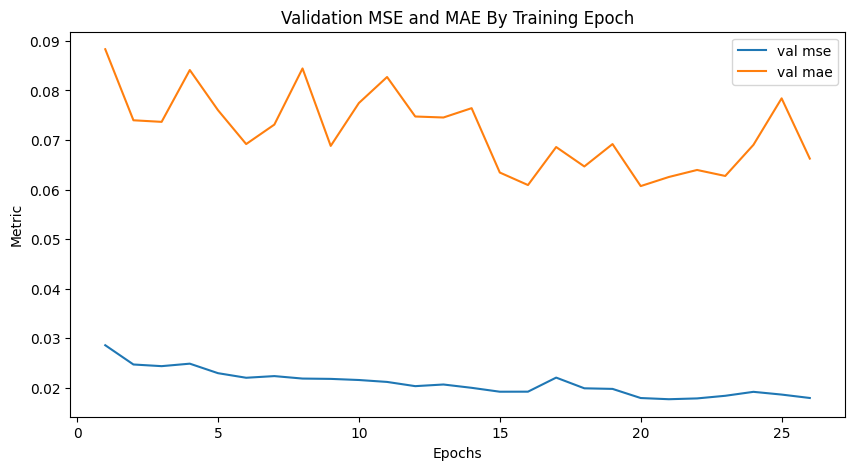

In [18]:
no_epochs = range(1, len(val_mse_epochs) + 1)

plt.figure(figsize=(10,5))
plt.title("Validation MSE and MAE By Training Epoch")
plt.plot(no_epochs, val_mse_epochs,label="val mse")
plt.plot(no_epochs, val_mae_epochs,label="val mae")
plt.xlabel("Epochs")
plt.ylabel("Metric")
plt.legend()
plt.show()

In [19]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
  for X, y in test_loader:
    X, y = X.to(DEVICE), y.to(DEVICE)
    preds = model(X)
    y_true.extend(y.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

mse  = np.mean((y_true - y_pred)**2)
mae  = np.mean(np.abs(y_true - y_pred))
per_rotor_mae = np.mean(np.abs(y_true - y_pred), axis=0)

print("Test MSE:", mse)
print("Test MAE:", mae)
print("Per-rotor MAE:", per_rotor_mae)

Test MSE: 0.017422806
Test MAE: 0.05852119
Per-rotor MAE: [0.06005801 0.06060779 0.05328726 0.06013181]


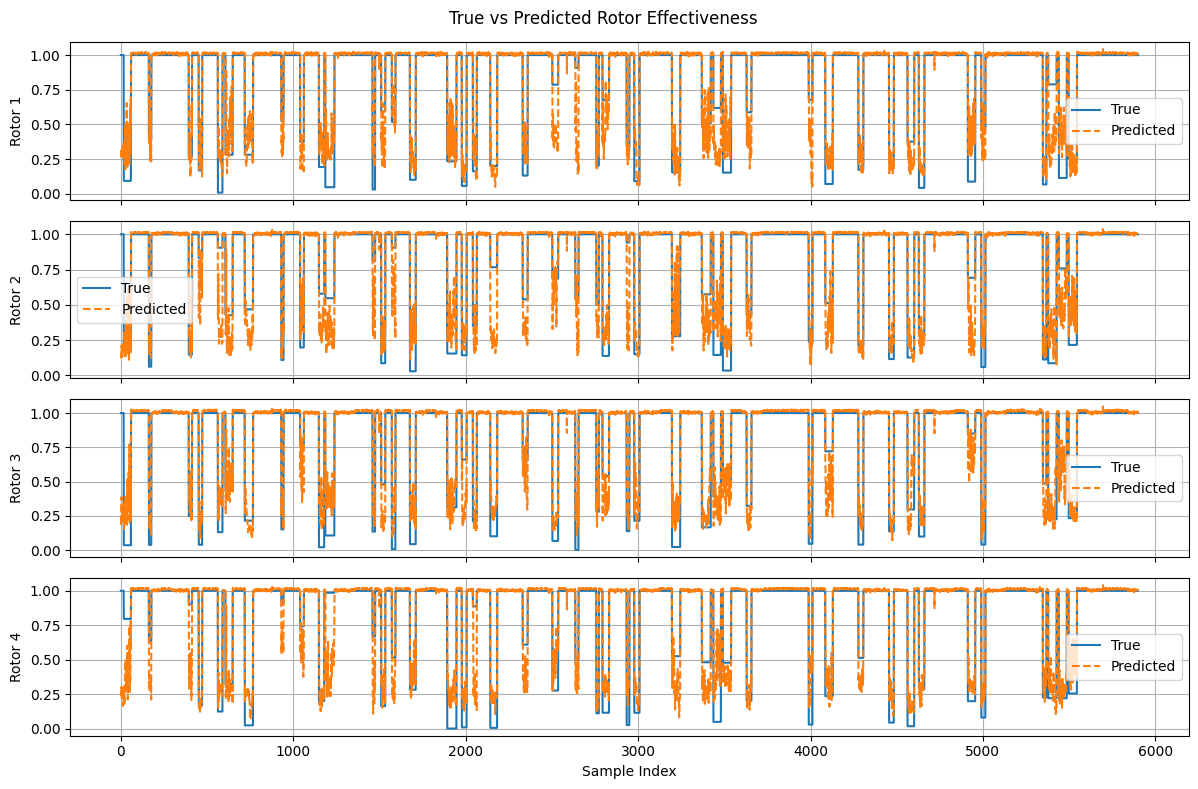

In [20]:
num_rotors = y_true.shape[1]
fig, axes = plt.subplots(num_rotors, 1, figsize=(12, 8), sharex=True)

for i in range(num_rotors):
    axes[i].plot(y_true[:, i], label=f"True")
    axes[i].plot(y_pred[:, i], label=f"Predicted", linestyle='--')
    axes[i].set_ylabel(f"Rotor {i+1}")
    axes[i].legend()
    axes[i].grid(True)

plt.xlabel("Sample Index")
plt.suptitle("True vs Predicted Rotor Effectiveness")
plt.tight_layout()
plt.show()